# Whole brain data processing

In [1]:
import numpy as np
import pandas as pd
import os, sys
from glob import glob
from h5py import File
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import dask.array as da
from utils import *
import time

## Set up environments

In [35]:
dir_root = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20161109/fish2/20161109_2_1_6dpf_GFAP_GC_Huc_RG_GA_CL_fb_OL_f0_0GAIN_20161109_211950/raw'
save_dir = ''
cameraNoiseMat = '/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'
numCores = 60

In [2]:
import fish_proc.utils.dask_ as fdask
cluster, client = fdask.setup_workers(numCores)
client

Client Scheduler: tcp://10.36.111.11:46028 Dashboard: http://10.36.111.11:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load file to dask

In [4]:
files = sorted(glob(dir_root+'/*.h5'))
chunks = File(files[0],'r')['default'].shape
files = files[::10] # this is for test purpose
data = da.stack([da.from_array(File(fn,'r')['default'], chunks=chunks) for fn in files])

## Pixel denoise
* Test of comparison -- see notebook test_data_compression

In [5]:
from fish_proc.utils.getCameraInfo import getCameraInfo
cameraInfo = getCameraInfo(dir_root)
denoised_data = data.map_blocks(lambda v: pixelDenoiseImag(v, cameraInfo=cameraInfo), dtype='float32')

In [6]:
if not os.path.exists('motion_fix_.h5'):
    med_win = len(denoised_data)
    ref_img = denoised_data[med_win-100:med_win+100].mean(axis=0).compute()
    save_h5('motion_fix_.h5', ref_img, dtype='float16')
else:
    ref_img = File('motion_fix_.h5', 'r')['default'].value

In [7]:
ref_img = ref_img.max(axis=0, keepdims=True)

## Registration

In [8]:
%%time
if not os.path.exists('trans_affs.npy'):
    trans_affine = denoised_data.map_blocks(lambda x: estimate_rigid2d(x, fixed=ref_img), dtype='float32', drop_axis=(3), chunks=(1,4,4)).compute()
    np.save('trans_affs', trans_affine)

CPU times: user 0 ns, sys: 972 µs, total: 972 µs
Wall time: 3.89 ms


In [9]:
trans_affine_ = np.load('trans_affs.npy')
trans_affine_ = da.from_array(trans_affine_, chunks=(1,4,4))

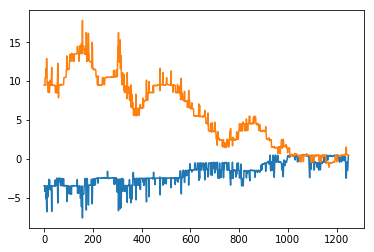

In [10]:
plt.plot(trans_affine_[:, 1, -1])
plt.plot(trans_affine_[:, 2, -1])
plt.show()

### Compute registered images
* z, x, y, t -- `trans_data_t` will be used for df/f computation after spatal component matrix is obtained

In [13]:
trans_data_ = da.map_blocks(apply_transform3d, denoised_data, trans_affine_, chunks=(1, *denoised_data.shape[1:]), dtype='float32')
chunk_x, chunk_y = chunks[-2:]
trans_data_t = trans_data_.transpose((1, 2, 3, 0)).rechunk((1, chunk_x//4, chunk_y//4, -1))

In [15]:
trans_data_t

dask.array<rechunk-merge, shape=(24, 2048, 2048, 1250), dtype=float32, chunksize=(1, 512, 512, 1250)>

## Video Detrend
* use more trackable video detrend algorithm -- for example running percentile instead of local fit -- this will saving space in trend data

In [39]:
baseline_t = trans_data_t.map_blocks(lambda v: baseline(v, window=100, percentile=20), dtype='float32')
Y_d = trans_data_t.map_blocks(lambda v: v - baseline(v, window=100, percentile=20), dtype='float32')

### test data

In [37]:
test_video_detrend = False
if test_video_detrend:
    test_ = trans_data_t[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)

    cluster.start_workers(numCores)
    test_baseline = baseline_t[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)

    cluster.start_workers(numCores)
    test_d = Y_d[12, 256, 256, :].compute()
    cluster.stop_all_jobs()
    time.sleep(10)
    
    plt.plot(test_)
    plt.plot(test_baseline)
    plt.title('F and basline')
    plt.show()
    min_ = np.min(np.percentile(test_, 0.3), 0)
    dff = test_d/(test_baseline-min_)
    plt.plot(dff)
    plt.title('df/f')
    plt.show()

## Local PCA
* This data should be saved as the sparse matrices

In [ ]:
if not os.path.exists(f'{save_dir}Y_2dnorm.npz'):
    cluster.start_workers(numCores)
    Y_d_ave = Y_d.mean(axis=-1, keepdims=True, dtype='float32').compute()
    cluster.stop_all_jobs()
    time.sleep(10)
    cluster.start_workers(numCores)
    Y_d_std = Y_d.std(axis=-1, keepdims=True, dtype='float32').compute()
    np.savez_compressed(f'{save_dir}Y_2dnorm', Y_d_ave=Y_d_ave, Y_d_std=Y_d_std)
    cluster.stop_all_jobs()
    time.sleep(10)
else:
    _ = np.load(f'{save_dir}Y_2dnorm.npz')
    Y_d_ave = _['Y_d_ave']
    Y_d_std = _['Y_d_std']

Worker tcp://10.36.60.13:42525 restart in Job 55916049. This can be due to memory issue.
Worker tcp://10.36.60.12:35748 restart in Job 55915986. This can be due to memory issue.
Worker tcp://10.36.60.41:38065 restart in Job 55916041. This can be due to memory issue.
Worker tcp://10.36.60.13:45697 restart in Job 55916050. This can be due to memory issue.
Worker tcp://10.36.60.32:34616 restart in Job 55916063. This can be due to memory issue.
Worker tcp://10.36.60.27:33025 restart in Job 55916059. This can be due to memory issue.
Worker tcp://10.36.60.11:40725 restart in Job 55915984. This can be due to memory issue.
Worker tcp://10.36.60.12:33753 restart in Job 55915987. This can be due to memory issue.
Worker tcp://10.36.60.30:36625 restart in Job 55915993. This can be due to memory issue.
Worker tcp://10.36.60.41:33025 restart in Job 55916040. This can be due to memory issue.
Worker tcp://10.36.60.27:33029 restart in Job 55916843. This can be due to memory issue.
Worker tcp://10.36.60

In [41]:
try:
    cluster.stop_all_jobs()
    time.sleep(10)
except:
    pass

In [ ]:
Y_d = (Y_d - Y_d_ave)/Y_d_std
xy_lap = 10 # overlap by 10 pixel in blocks
g = da.overlap.overlap(Y_d, depth={1: xy_lap, 2: xy_lap}, boundary={1: 0, 2: 0})

In [ ]:
# check data
print(Y_d)
print(g)

In [ ]:
# test code for local_pca
def local_pca_test(block, block_id=None):
    # this check the input data is as designed
    from multi
    print(block.shape)
    return np.zeros([1]*len(block_id))

In [ ]:
def local_pca(block, block_id=None):
    from fish_proc.denoiseLocalPCA.denoise import temporal as svd_patch
    from numpy import expand_dims
    dx=4
    nblocks=[20, 20]
    Y_svd, _ = svd_patch(block.squeeze(), nblocks=nblocks, dx=dx, stim_knots=None, stim_delta=0)
    return expand_dims(Y_svd, 0)

Worker tcp://10.36.60.12:42887 restart in Job 55910878. This can be due to memory issue.


In [ ]:
# this is a test
Y_svd = g.map_blocks(local_pca_test, dtype='float32', chunks=(1, 1, 1, 1))
Y_svd.compute()

In [ ]:
# this is a test for middle layers
Y_svd = g[12:14].map_blocks(local_pca, dtype='float32', chunks=(1, 1, 1, 1))
Y_svd.compute()

In [29]:
Y_svd = da.overlap.trim_internal(Y_svd, {1: xy_lap, 2: xy_lap})

## Demix
* down-sample in time

In [ ]:
dt = 2
mov = Y_svd[::dt]

In [ ]:
# check if the chunks are as designed
mov

In [ ]:


def demix_components(ext=''):
    dat_xls_file = pd.read_csv(dat_csv, index_col=0)
    dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
    for index, row in dat_xls_file.iterrows():
        try:
            demix_middle_data_with_mask(row, ext=ext)
        except Exception as err:
            folder = row['folder']
            fish = row['fish']
            save_folder = dat_folder + f'{folder}/{fish}/Data'
            print(f'Demix failed on file {folder}/{fish}: {err}')
            os.remove(save_folder+f'/proc_demix{ext}.tmp')
    return None


def demix_middle_data_with_mask(row, ext='', ismask=True):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from pathlib import Path
    from skimage.external.tifffile import imsave, imread
    from fish_proc.demix import superpixel_analysis as sup
    from fish_proc.utils.snr import correlation_pnr
    from fish_proc.utils.noise_estimator import get_noise_fft
    import pickle
    sns.set(font_scale=2)
    sns.set_style("white")
    # mask out the region with low snr

    folder = row['folder']
    fish = row['fish']
    save_folder = dat_folder + f'{folder}/{fish}/Data'
    save_image_folder = dat_folder + f'{folder}/{fish}/Results'
    if not os.path.exists(save_image_folder):
        os.makedirs(save_image_folder)
    print('=====================================')
    print(save_folder)

    if os.path.isfile(save_folder+f'/finished_demix{ext}.tmp'):
        return None

    if not os.path.isfile(save_folder+f'/finished_local_denoise.tmp'):
        return None

    if not os.path.isfile(save_folder+f'/proc_demix{ext}.tmp'):
        Path(save_folder+f'/proc_demix{ext}.tmp').touch()
        _ = np.load(f'{save_folder}/Y_2dnorm.npz')
        Y_d_std= _['Y_d_std']
        
        # if Y_svd not exist, generate file
        if not os.path.isfile(f'{save_folder}/Y_svd.tif'):
            Y_svd = []
            for n_ in range(10):
                Y_svd.append(np.load(f'{save_folder}/Y_2dsvd{n_}.npy').astype('float32'))
            Y_svd = np.concatenate(Y_svd, axis=-1)
            print(Y_svd.shape)
            imsave(f'{save_folder}/Y_svd.tif', Y_svd.astype('float32'), compress=1)
            print('Concatenate files into a tif file')
            get_process_memory();
            
            for n_ in range(10):
                if os.path.isfile(f'{save_folder}/Y_2dsvd{n_}.npy'):
                    os.remove(f'{save_folder}/Y_2dsvd{n_}.npy')
        
        # save preprocessed data in case of unsuccessful demix 
        # make mask
        if ismask:
            if not os.path.exists(f'{save_folder}/mask.npz'):
                try:
                    Y_svd
                except NameError:
                    Y_svd = imread(f'{save_folder}/Y_svd.tif').astype('float32')
                mean_ = Y_svd.mean(axis=-1,keepdims=True)
                sn, _ = get_noise_fft(Y_svd - mean_,noise_method='logmexp')
                SNR_ = Y_svd.var(axis=-1)/sn**2
                std_thres = np.percentile(Y_d_std.ravel(), 80)
                mask = Y_d_std.squeeze(axis=-1)<=std_thres
                snr_thres = np.percentile(np.log(SNR_).ravel(), 0)
                mask = np.logical_or(mask, np.log(SNR_)<snr_thres)
                mask_out_region = np.logical_not(mask)
                mask_save = np.where(mask_out_region)
                np.savez(f'{save_folder}/mask', mask=mask, mask_save=mask_save)
            else:
                _ = np.load(f'{save_folder}/mask.npz')
                mask = _['mask']
                mask_save = _['mask_save']
        else:
            d1, d2, _ = Y_d_std.shape
            mask = np.full((d1, d2), False)
            mask_save = np.where(np.full((d1, d2), True))

        if not os.path.exists(f'{save_folder}/demix_mov.npz'):
            try:
                Y_svd
            except NameError:
                Y_svd = imread(f'{save_folder}/Y_svd.tif').astype('float32')
            # get move data
            len_Y = Y_svd.shape[-1]
            mov_ = Y_svd[mask_save[0].min():mask_save[0].max(), mask_save[1].min():mask_save[1].max(), len_Y//3:-len_Y//3]
            Y_svd = None
            clear_variables(Y_svd)
            get_process_memory();    
            # get sparse data
            Y_d_std_ = Y_d_std[mask_save[0].min():mask_save[0].max(), mask_save[1].min():mask_save[1].max(), :]
            mov_ = mov_*Y_d_std_ + np.random.normal(size=mov_.shape)*0.7
            mov_ = -mov_.astype('float32')
            mask_ = mask[mask_save[0].min():mask_save[0].max(), mask_save[1].min():mask_save[1].max()]
            mov_[mask_]=0 
            mov_ = mov_.astype('float32')
            # get local correlation distribution
            Cn, _ = correlation_pnr(mov_, skip_pnr=True)
            np.savez(f'{save_folder}/demix_mov', mov_ = mov_, Cn=Cn)
        else:
            _ = np.load(f'{save_folder}/demix_mov.npz')
            mov_ = _['mov_'].astype('float32')
            Cn = _['Cn']
        
        get_process_memory();
        d1, d2, _ = mov_.shape

        is_demix = False
        pass_num = 4
        cut_off_point=np.percentile(Cn.ravel(), [99, 95, 85, 65])
        while not is_demix and pass_num>=0:
            try:
                rlt_= sup.demix_whole_data(mov_, cut_off_point[4-pass_num:], length_cut=[10,15,15,15],
                                           th=[1,1,1,1], pass_num=pass_num, residual_cut = [0.6,0.6,0.6,0.6],
                                           corr_th_fix=0.3, max_allow_neuron_size=0.05, merge_corr_thr=cut_off_point[-1],
                                           merge_overlap_thr=0.6, num_plane=1, patch_size=[40, 40], plot_en=False,
                                           TF=False, fudge_factor=1, text=False, bg=False, max_iter=60,
                                           max_iter_fin=100, update_after=20)
                is_demix = True
            except:
                print(f'fail at pass_num {pass_num}')
                is_demix = False
                pass_num -= 1

        with open(f'{save_folder}/period_Y_demix{ext}_rlt.pkl', 'wb') as f:
            pickle.dump(rlt_, f)

        print('Result file saved?')
        print(os.path.isfile(f'{save_folder}/period_Y_demix{ext}_rlt.pkl'))

        with open(f'{save_folder}/period_Y_demix{ext}_rlt.pkl', 'rb') as f:
            rlt_ = pickle.load(f)

        if not os.path.isfile(f'{save_folder}/Y_trend_ave.npy'):
            Y_mean = imread(f'{save_folder}/imgDMotion.tif').mean(axis=0)
            Y_d_mean = imread(f'{save_folder}/Y_d.tif').mean(axis=-1)
            Y_trend_ave = Y_mean - Y_d_mean
            Y_mean = None
            Y_d_mean = None
            clear_variables((Y_d_mean, Y_mean, mov_))
            np.save(f'{save_folder}/Y_trend_ave', Y_trend_ave)
        else:
            Y_trend_ave = np.load(f'{save_folder}/Y_trend_ave.npy')

        Y_trend_ave = Y_trend_ave[mask_save[0].min():mask_save[0].max(), mask_save[1].min():mask_save[1].max()]

        A = rlt_['fin_rlt']['a']
        A_ = A[:, (A>0).sum(axis=0)>0]
        A_comp = np.zeros(A_.shape[0])
        A_comp[A_.sum(axis=-1)>0] = np.argmax(A_[A_.sum(axis=-1)>0, :], axis=-1) + 1
        plt.figure(figsize=(8,4))
        plt.imshow(Y_trend_ave, cmap=plt.cm.gray)
        plt.imshow(A_comp.reshape(d2, d1).T, cmap=plt.cm.nipy_spectral_r, alpha=0.7)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'{save_image_folder}/Demixed_components{ext}.png')
        plt.close()
        Path(save_folder+f'/finished_demix{ext}.tmp').touch()
    return None